In [2]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [3]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu
from suite3d import nbtools as nbui
from suite3d import extension as ext

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [4]:
subjects_dir =   '/mnt/zortex-subjects/'
expt_info = { 
    'subject':         'SS004',
    'date' :          '2024-08-13',
    'expnum' :         list(n.arange(1,21))}

tifs, si_params, exp_str = flu.find_exp(subjects_dir, **expt_info, verbose=False)

job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 26,
    # number of planes in the deeper cavity, typically 15
    'cavity_size' : 13,
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'planes' : n.array([ 0,  2,  4,  6,  8, 10, 12, 14,
                        16, 18, 20, 22, 24, 1,  3, 5,  7,9,11, 13, 15,17,19,21]),
    # number of files to use for the initial pass
    'n_init_files' :   4,
    
    # number of pixels to fuse between the ROI strips
    # the auto-detection doesn't always work well, recommend 
    # manually tuning it to reduce the stitching artifacts
    'fuse_shift_override' : 6,
    
    # will try to automatically estimate crosstalk using 
    # the shallowest crosstalk_n_planes planes. if you want to override,
    # set override_crosstalk = float between 0 and 1
    'subtract_crosstalk' : True,
    
    # volume rate in acquisition
    'fs' : flu.get_si_params(tifs[0])['vol_rate'],
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'nonrigid' : False,
    'gpu_reg' : True,
    'save_dtype' : 'float16',
}

In [5]:

job_params['fs'] = si_params['vol_rate']

savedir = os.path.join('/mnt/md0/runs', expt_info['subject'], expt_info['date'])
os.makedirs(savedir, exist_ok=True)

# Create the job
job = Job('/mnt/md0/runs',exp_str, tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20 already exists
Loading job directory for SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20 in /mnt/md0/runs
   Loading dirs 
      Found dir registered_fused_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param n_ch_tif
      Updating param cavity_size
      Updating param planes
      Updating param n_init_files
      Updating param fuse_shift_override
      Updating param subtract_crosstalk
      Updating param fs
      Updating param 3d_reg
      Updating param nonrigid
      Updating param gpu_reg
      Updating param save_dtype
   Updated main params file


In [6]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 4
job.params['init_n_frames'] = None
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (20, 2.5, 2.5)

In [7]:
# %%time
# summary = job.run_init_pass()

In [8]:
summary = job.load_summary()

In [9]:
img = summary['ref_img_3d']

In [10]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [11]:
# %%time
# job.register()

In [36]:
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy_um'] = 200
job.params['cell_filt_type'] = 'gaussian'
job.params['cell_filt_xy_um'] = 5
job.params['sdnorm_exp'] = 0.85
job.params['intensity_thresh'] = 1.0
job.params['standard_vmap'] = True
job.params['t_batch_size'] = 600
job.params['n_proc_corr'] = 64
job.params['n_proc'] = 64
job.params['detection_timebin'] = 6

corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/corrmap
   Updated main params file
   Computing correlation map of movie with 49106 frames, volume shape: 24, 1037, 746
      Running batch 1 of 82
      Binning with timebin of size 06
         Timer batch_timebin completed in 0.001 sec


/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 12.896 sec
         Timer batch_setup completed in 1.949 sec
         Timer batch_edgecrop completed in 0.153 sec
         Timer accum_meanmeax completed in 1.744 sec
         Timer batch_rolling_mean_filt completed in 1.489 sec
         Timer batch_accum_sdmov completed in 4.550 sec
         Timer batch_norm_sdmov completed in 0.786 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.953 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.885 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.080 sec
         Timer dtu_cleanup completed in 3.249 sec
         Timer batch_filt_reduce completed in 26.168 sec
         Timer batch_accum_vmap completed in 0.076 sec
         Timer batch completed in 42.579 sec
         Timer save completed in 5.052 sec
      Running batch 2 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.543 sec
         Timer batch_setup completed in 1.905 sec
         Timer batch_edgecrop completed in 0.150 sec
         Timer accum_meanmeax completed in 1.781 sec
         Timer batch_rolling_mean_filt completed in 1.449 sec
         Timer batch_accum_sdmov completed in 4.455 sec
         Timer batch_norm_sdmov completed in 0.757 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.663 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.139 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.006 sec
         Timer dtu_cleanup completed in 3.058 sec
         Timer batch_filt_reduce completed in 24.868 sec
         Timer batch_accum_vmap completed in 0.075 sec
         Timer batch completed in 41.634 sec
         Timer save completed in 5.014 sec
      Running batch 3 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.283 sec
         Timer batch_setup completed in 1.893 sec
         Timer batch_edgecrop completed in 0.213 sec
         Timer accum_meanmeax completed in 1.759 sec
         Timer batch_rolling_mean_filt completed in 1.428 sec
         Timer batch_accum_sdmov completed in 4.424 sec
         Timer batch_norm_sdmov completed in 0.761 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.649 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.900 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.990 sec
         Timer dtu_cleanup completed in 2.759 sec
         Timer batch_filt_reduce completed in 24.300 sec
         Timer batch_accum_vmap completed in 0.098 sec
         Timer batch completed in 40.795 sec
         Timer save completed in 4.971 sec
      Running batch 4 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.065 sec
         Timer batch_setup completed in 1.902 sec
         Timer batch_edgecrop completed in 0.156 sec
         Timer accum_meanmeax completed in 1.737 sec
         Timer batch_rolling_mean_filt completed in 1.432 sec
         Timer batch_accum_sdmov completed in 4.428 sec
         Timer batch_norm_sdmov completed in 0.758 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.607 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.056 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.993 sec
         Timer dtu_cleanup completed in 2.708 sec
         Timer batch_filt_reduce completed in 24.366 sec
         Timer batch_accum_vmap completed in 0.073 sec
         Timer batch completed in 40.694 sec
         Timer save completed in 4.947 sec
      Running batch 5 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.081 sec
         Timer batch_setup completed in 1.910 sec
         Timer batch_edgecrop completed in 0.191 sec
         Timer accum_meanmeax completed in 1.741 sec
         Timer batch_rolling_mean_filt completed in 1.441 sec
         Timer batch_accum_sdmov completed in 4.461 sec
         Timer batch_norm_sdmov completed in 0.760 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.686 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.864 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.040 sec
         Timer dtu_cleanup completed in 2.707 sec
         Timer batch_filt_reduce completed in 24.298 sec
         Timer batch_accum_vmap completed in 0.095 sec
         Timer batch completed in 40.720 sec
         Timer save completed in 4.952 sec
      Running batch 6 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.450 sec
         Timer batch_setup completed in 1.899 sec
         Timer batch_edgecrop completed in 0.216 sec
         Timer accum_meanmeax completed in 1.719 sec
         Timer batch_rolling_mean_filt completed in 1.448 sec
         Timer batch_accum_sdmov completed in 4.442 sec
         Timer batch_norm_sdmov completed in 0.757 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.599 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.043 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.989 sec
         Timer dtu_cleanup completed in 2.687 sec
         Timer batch_filt_reduce completed in 24.321 sec
         Timer batch_accum_vmap completed in 0.074 sec
         Timer batch completed in 40.749 sec
         Timer save completed in 4.969 sec
      Running batch 7 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.476 sec
         Timer batch_setup completed in 1.965 sec
         Timer batch_edgecrop completed in 0.237 sec
         Timer accum_meanmeax completed in 1.787 sec
         Timer batch_rolling_mean_filt completed in 1.499 sec
         Timer batch_accum_sdmov completed in 4.581 sec
         Timer batch_norm_sdmov completed in 0.789 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.743 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.846 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.095 sec
         Timer dtu_cleanup completed in 2.737 sec
         Timer batch_filt_reduce completed in 24.423 sec
         Timer batch_accum_vmap completed in 0.096 sec
         Timer batch completed in 41.112 sec
         Timer save completed in 4.966 sec
      Running batch 8 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.426 sec
         Timer batch_setup completed in 1.936 sec
         Timer batch_edgecrop completed in 0.166 sec
         Timer accum_meanmeax completed in 1.794 sec
         Timer batch_rolling_mean_filt completed in 1.516 sec
         Timer batch_accum_sdmov completed in 4.628 sec
         Timer batch_norm_sdmov completed in 0.797 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.682 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.314 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.128 sec
         Timer dtu_cleanup completed in 2.713 sec
         Timer batch_filt_reduce completed in 24.839 sec
         Timer batch_accum_vmap completed in 0.080 sec
         Timer batch completed in 41.549 sec
         Timer save completed in 5.003 sec
      Running batch 9 of 82
      Binni

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 14.041 sec
         Timer batch_setup completed in 1.703 sec
         Timer batch_edgecrop completed in 0.216 sec
         Timer accum_meanmeax completed in 1.727 sec
         Timer batch_rolling_mean_filt completed in 1.433 sec
         Timer batch_accum_sdmov completed in 4.430 sec
         Timer batch_norm_sdmov completed in 0.760 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.622 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.848 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.996 sec
         Timer dtu_cleanup completed in 2.689 sec
         Timer batch_filt_reduce completed in 24.158 sec
         Timer batch_accum_vmap completed in 0.094 sec
         Timer batch completed in 40.419 sec
         Timer save completed in 4.975 sec
      Running batch 10 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 20.289 sec
         Timer batch_setup completed in 1.732 sec
         Timer batch_edgecrop completed in 0.169 sec
         Timer accum_meanmeax completed in 1.760 sec
         Timer batch_rolling_mean_filt completed in 1.475 sec
         Timer batch_accum_sdmov completed in 4.528 sec
         Timer batch_norm_sdmov completed in 0.777 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.943 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.251 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.064 sec
         Timer dtu_cleanup completed in 3.161 sec
         Timer batch_filt_reduce completed in 25.422 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.727 sec
         Timer save completed in 5.051 sec
      Running batch 11 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.697 sec
         Timer batch_setup completed in 1.746 sec
         Timer batch_edgecrop completed in 0.185 sec
         Timer accum_meanmeax completed in 1.791 sec
         Timer batch_rolling_mean_filt completed in 1.513 sec
         Timer batch_accum_sdmov completed in 4.626 sec
         Timer batch_norm_sdmov completed in 0.801 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.753 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.983 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.130 sec
         Timer dtu_shmem completed in 5.667 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.025 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.999 sec
         Timer dtu_cle

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 14.521 sec
         Timer batch_setup completed in 1.940 sec
         Timer batch_edgecrop completed in 0.231 sec
         Timer accum_meanmeax completed in 1.759 sec
         Timer batch_rolling_mean_filt completed in 1.502 sec
         Timer batch_accum_sdmov completed in 4.547 sec
         Timer batch_norm_sdmov completed in 0.790 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.738 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.005 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.067 sec
         Timer dtu_cleanup completed in 2.736 sec
         Timer batch_filt_reduce completed in 24.547 sec
         Timer batch_accum_vmap completed in 0.100 sec
         Timer batch completed in 41.195 sec
         Timer save completed in 4.953 sec
      Running batch 14 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 15.497 sec
         Timer batch_setup completed in 1.938 sec
         Timer batch_edgecrop completed in 0.152 sec
         Timer accum_meanmeax completed in 1.731 sec
         Timer batch_rolling_mean_filt completed in 1.470 sec
         Timer batch_accum_sdmov completed in 4.508 sec
         Timer batch_norm_sdmov completed in 0.774 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.664 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_shmem completed in 5.764 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.878 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.052 sec
         Timer dtu_cleanup completed in 2.757 sec
         Timer batch_filt_reduce completed in 24.453 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch co

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 16.149 sec
         Timer batch_setup completed in 1.944 sec
         Timer batch_edgecrop completed in 0.183 sec
         Timer accum_meanmeax completed in 1.736 sec
         Timer batch_rolling_mean_filt completed in 1.483 sec
         Timer batch_accum_sdmov completed in 4.544 sec
         Timer batch_norm_sdmov completed in 0.785 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.820 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.830 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.103 sec
         Timer dtu_cleanup completed in 2.963 sec
         Timer batch_filt_reduce completed in 24.719 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 41.213 sec
         Timer save completed in 5.074 sec
      Running batch 18 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 17.393 sec
         Timer batch_setup completed in 1.768 sec
         Timer batch_edgecrop completed in 0.162 sec
         Timer accum_meanmeax completed in 1.769 sec
         Timer batch_rolling_mean_filt completed in 1.514 sec
         Timer batch_accum_sdmov completed in 4.664 sec
         Timer batch_norm_sdmov completed in 0.797 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.843 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.178 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.136 sec
         Timer dtu_cleanup completed in 3.071 sec
         Timer batch_filt_reduce completed in 25.231 sec
         Timer batch_accum_vmap completed in 0.079 sec
         Timer batch completed in 41.888 sec
         Timer save completed in 5.192 sec
      Running batch 19 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.385 sec
         Timer batch_setup completed in 1.722 sec
         Timer batch_edgecrop completed in 0.173 sec
         Timer accum_meanmeax completed in 1.672 sec
         Timer batch_rolling_mean_filt completed in 1.425 sec
         Timer batch_accum_sdmov completed in 4.471 sec
         Timer batch_norm_sdmov completed in 0.753 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.696 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.186 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.003 sec
         Timer dtu_cleanup completed in 2.894 sec
         Timer batch_filt_reduce completed in 24.786 sec
         Timer batch_accum_vmap completed in 0.101 sec
         Timer batch completed in 41.090 sec
         Timer save completed in 5.005 sec
      Running batch 20 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.095 sec
         Timer batch_setup completed in 1.934 sec
         Timer batch_edgecrop completed in 0.151 sec
         Timer accum_meanmeax completed in 1.703 sec
         Timer batch_rolling_mean_filt completed in 1.450 sec
         Timer batch_accum_sdmov completed in 4.514 sec
         Timer batch_norm_sdmov completed in 0.771 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.752 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.013 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.019 sec
         Timer dtu_cleanup completed in 2.738 sec
         Timer batch_filt_reduce completed in 24.524 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.002 sec
         Timer save completed in 5.003 sec
      Running batch 21 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.222 sec
         Timer batch_setup completed in 1.731 sec
         Timer batch_edgecrop completed in 0.156 sec
         Timer accum_meanmeax completed in 1.696 sec
         Timer batch_rolling_mean_filt completed in 1.490 sec
         Timer batch_accum_sdmov completed in 4.569 sec
         Timer batch_norm_sdmov completed in 0.780 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.700 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.906 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.068 sec
         Timer dtu_cleanup completed in 2.820 sec
         Timer batch_filt_reduce completed in 24.496 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 40.947 sec
         Timer save completed in 5.028 sec
      Running batch 22 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 15.859 sec
         Timer batch_setup completed in 1.727 sec
         Timer batch_edgecrop completed in 0.215 sec
         Timer accum_meanmeax completed in 1.671 sec
         Timer batch_rolling_mean_filt completed in 1.431 sec
         Timer batch_accum_sdmov completed in 4.474 sec
         Timer batch_norm_sdmov completed in 0.761 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.637 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.046 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.986 sec
         Timer dtu_cleanup completed in 2.764 sec
         Timer batch_filt_reduce completed in 24.435 sec
         Timer batch_accum_vmap completed in 0.078 sec
         Timer batch completed in 40.624 sec
         Timer save completed in 4.994 sec
      Running batch 23 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 16.094 sec
         Timer batch_setup completed in 1.947 sec
         Timer batch_edgecrop completed in 0.188 sec
         Timer accum_meanmeax completed in 1.704 sec
         Timer batch_rolling_mean_filt completed in 1.457 sec
         Timer batch_accum_sdmov completed in 4.532 sec
         Timer batch_norm_sdmov completed in 0.767 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.720 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.963 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.037 sec
         Timer dtu_cleanup completed in 2.867 sec
         Timer batch_filt_reduce completed in 24.590 sec
         Timer batch_accum_vmap completed in 0.101 sec
         Timer batch completed in 41.046 sec
         Timer save completed in 4.994 sec
      Running batch 24 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.073 sec
         Timer batch_setup completed in 1.747 sec
         Timer batch_edgecrop completed in 0.226 sec
         Timer accum_meanmeax completed in 1.711 sec
         Timer batch_rolling_mean_filt completed in 1.468 sec
         Timer batch_accum_sdmov completed in 4.558 sec
         Timer batch_norm_sdmov completed in 0.775 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.797 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.970 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.060 sec
         Timer dtu_cleanup completed in 2.793 sec
         Timer batch_filt_reduce completed in 24.622 sec
         Timer batch_accum_vmap completed in 0.079 sec
         Timer batch completed in 41.025 sec
         Timer save completed in 5.025 sec
      Running batch 25 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.822 sec
         Timer batch_setup completed in 1.959 sec
         Timer batch_edgecrop completed in 0.156 sec
         Timer accum_meanmeax completed in 1.717 sec
         Timer batch_rolling_mean_filt completed in 1.471 sec
         Timer batch_accum_sdmov completed in 4.546 sec
         Timer batch_norm_sdmov completed in 0.781 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.873 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.127 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.044 sec
         Timer dtu_cleanup completed in 2.881 sec
         Timer batch_filt_reduce completed in 24.927 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 41.520 sec
         Timer save completed in 5.039 sec
      Running batch 26 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 15.447 sec
         Timer batch_setup completed in 1.723 sec
         Timer batch_edgecrop completed in 0.158 sec
         Timer accum_meanmeax completed in 1.678 sec
         Timer batch_rolling_mean_filt completed in 1.437 sec
         Timer batch_accum_sdmov completed in 4.478 sec
         Timer batch_norm_sdmov completed in 0.769 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.686 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.215 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.028 sec
         Timer dtu_cleanup completed in 2.819 sec
         Timer batch_filt_reduce completed in 24.750 sec
         Timer batch_accum_vmap completed in 0.081 sec
         Timer batch completed in 41.014 sec
         Timer save completed in 5.065 sec
      Running batch 27 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 20.377 sec
         Timer batch_setup completed in 1.723 sec
         Timer batch_edgecrop completed in 0.219 sec
         Timer accum_meanmeax completed in 1.680 sec
         Timer batch_rolling_mean_filt completed in 1.436 sec
         Timer batch_accum_sdmov completed in 4.492 sec
         Timer batch_norm_sdmov completed in 0.761 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.737 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.834 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.010 sec
         Timer dtu_cleanup completed in 2.874 sec
         Timer batch_filt_reduce completed in 24.457 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 40.749 sec
         Timer save completed in 5.038 sec
      Running batch 28 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 16.839 sec
         Timer batch_setup completed in 1.927 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.682 sec
         Timer batch_rolling_mean_filt completed in 1.440 sec
         Timer batch_accum_sdmov completed in 4.480 sec
         Timer batch_norm_sdmov completed in 0.758 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.694 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.948 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.998 sec
         Timer dtu_cleanup completed in 2.852 sec
         Timer batch_filt_reduce completed in 24.495 sec
         Timer batch_accum_vmap completed in 0.081 sec
         Timer batch completed in 40.862 sec
         Timer save completed in 5.226 sec
      Running batch 29 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 17.167 sec
         Timer batch_setup completed in 1.921 sec
         Timer batch_edgecrop completed in 0.213 sec
         Timer accum_meanmeax completed in 1.657 sec
         Timer batch_rolling_mean_filt completed in 1.415 sec
         Timer batch_accum_sdmov completed in 4.454 sec
         Timer batch_norm_sdmov completed in 0.752 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.648 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.939 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.979 sec
         Timer dtu_cleanup completed in 2.811 sec
         Timer batch_filt_reduce completed in 24.379 sec
         Timer batch_accum_vmap completed in 0.105 sec
         Timer batch completed in 40.870 sec
         Timer save completed in 5.055 sec
      Running batch 30 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 18.131 sec
         Timer batch_setup completed in 1.930 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.684 sec
         Timer batch_rolling_mean_filt completed in 1.443 sec
         Timer batch_accum_sdmov completed in 4.488 sec
         Timer batch_norm_sdmov completed in 0.761 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.725 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.881 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.033 sec
         Timer dtu_cleanup completed in 2.879 sec
         Timer batch_filt_reduce completed in 24.526 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 40.969 sec
         Timer save completed in 5.054 sec
      Running batch 31 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.367 sec
         Timer batch_setup completed in 1.961 sec
         Timer batch_edgecrop completed in 0.225 sec
         Timer accum_meanmeax completed in 1.707 sec
         Timer batch_rolling_mean_filt completed in 1.466 sec
         Timer batch_accum_sdmov completed in 4.551 sec
         Timer batch_norm_sdmov completed in 0.772 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.779 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.932 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.052 sec
         Timer dtu_cleanup completed in 2.981 sec
         Timer batch_filt_reduce completed in 24.745 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 41.346 sec
         Timer save completed in 5.133 sec
      Running batch 32 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.404 sec
         Timer batch_setup completed in 1.730 sec
         Timer batch_edgecrop completed in 0.217 sec
         Timer accum_meanmeax completed in 1.671 sec
         Timer batch_rolling_mean_filt completed in 1.432 sec
         Timer batch_accum_sdmov completed in 4.514 sec
         Timer batch_norm_sdmov completed in 0.768 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.656 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.032 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.010 sec
         Timer dtu_cleanup completed in 2.738 sec
         Timer batch_filt_reduce completed in 24.438 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 40.671 sec
         Timer save completed in 5.004 sec
      Running batch 33 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 21.317 sec
         Timer batch_setup completed in 1.730 sec
         Timer batch_edgecrop completed in 0.149 sec
         Timer accum_meanmeax completed in 1.666 sec
         Timer batch_rolling_mean_filt completed in 1.434 sec
         Timer batch_accum_sdmov completed in 4.491 sec
         Timer batch_norm_sdmov completed in 0.759 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.734 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.076 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.028 sec
         Timer dtu_cleanup completed in 2.948 sec
         Timer batch_filt_reduce completed in 24.788 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 41.033 sec
         Timer save completed in 5.064 sec
      Running batch 34 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.964 sec
         Timer batch_setup completed in 1.737 sec
         Timer batch_edgecrop completed in 0.220 sec
         Timer accum_meanmeax completed in 1.678 sec
         Timer batch_rolling_mean_filt completed in 1.453 sec
         Timer batch_accum_sdmov completed in 4.572 sec
         Timer batch_norm_sdmov completed in 0.763 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.746 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.092 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.054 sec
         Timer dtu_cleanup completed in 2.802 sec
         Timer batch_filt_reduce completed in 24.696 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.007 sec
         Timer save completed in 5.046 sec
      Running batch 35 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 17.483 sec
         Timer batch_setup completed in 1.968 sec
         Timer batch_edgecrop completed in 0.167 sec
         Timer accum_meanmeax completed in 1.698 sec
         Timer batch_rolling_mean_filt completed in 1.468 sec
         Timer batch_accum_sdmov completed in 4.559 sec
         Timer batch_norm_sdmov completed in 0.782 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.769 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.906 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.043 sec
         Timer dtu_cleanup completed in 2.963 sec
         Timer batch_filt_reduce completed in 24.683 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 41.356 sec
         Timer save completed in 5.068 sec
      Running batch 36 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.185 sec
         Timer batch_setup completed in 1.964 sec
         Timer batch_edgecrop completed in 0.227 sec
         Timer accum_meanmeax completed in 1.704 sec
         Timer batch_rolling_mean_filt completed in 1.469 sec
         Timer batch_accum_sdmov completed in 4.561 sec
         Timer batch_norm_sdmov completed in 0.774 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.702 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.044 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.991 sec
         Timer dtu_cleanup completed in 2.735 sec
         Timer batch_filt_reduce completed in 24.475 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.157 sec
         Timer save completed in 5.051 sec
      Running batch 37 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 20.506 sec
         Timer batch_setup completed in 1.937 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.671 sec
         Timer batch_rolling_mean_filt completed in 1.434 sec
         Timer batch_accum_sdmov completed in 4.501 sec
         Timer batch_norm_sdmov completed in 0.768 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.749 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.930 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.046 sec
         Timer dtu_cleanup completed in 2.950 sec
         Timer batch_filt_reduce completed in 24.683 sec
         Timer batch_accum_vmap completed in 0.100 sec
         Timer batch completed in 41.197 sec
         Timer save completed in 5.082 sec
      Running batch 38 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 16.508 sec
         Timer batch_setup completed in 1.919 sec
         Timer batch_edgecrop completed in 0.224 sec
         Timer accum_meanmeax completed in 1.684 sec
         Timer batch_rolling_mean_filt completed in 1.462 sec
         Timer batch_accum_sdmov completed in 4.480 sec
         Timer batch_norm_sdmov completed in 0.767 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.661 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.946 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.039 sec
         Timer dtu_cleanup completed in 2.794 sec
         Timer batch_filt_reduce completed in 24.442 sec
         Timer batch_accum_vmap completed in 0.082 sec
         Timer batch completed in 40.911 sec
         Timer save completed in 5.078 sec
      Running batch 39 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 15.069 sec
         Timer batch_setup completed in 1.745 sec
         Timer batch_edgecrop completed in 0.154 sec
         Timer accum_meanmeax completed in 1.731 sec
         Timer batch_rolling_mean_filt completed in 1.494 sec
         Timer batch_accum_sdmov completed in 4.576 sec
         Timer batch_norm_sdmov completed in 0.789 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.752 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.846 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.086 sec
         Timer dtu_cleanup completed in 2.845 sec
         Timer batch_filt_reduce completed in 24.531 sec
         Timer batch_accum_vmap completed in 0.105 sec
         Timer batch completed in 41.021 sec
         Timer save completed in 5.064 sec
      Running batch 40 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 23.886 sec
         Timer batch_setup completed in 1.709 sec
         Timer batch_edgecrop completed in 0.216 sec
         Timer accum_meanmeax completed in 1.676 sec
         Timer batch_rolling_mean_filt completed in 1.432 sec
         Timer batch_accum_sdmov completed in 4.461 sec
         Timer batch_norm_sdmov completed in 0.771 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.793 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.043 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.994 sec
         Timer dtu_cleanup completed in 2.977 sec
         Timer batch_filt_reduce completed in 24.809 sec
         Timer batch_accum_vmap completed in 0.083 sec
         Timer batch completed in 41.120 sec
         Timer save completed in 5.047 sec
      Running batch 41 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 13.399 sec
         Timer batch_setup completed in 1.939 sec
         Timer batch_edgecrop completed in 0.238 sec
         Timer accum_meanmeax completed in 1.753 sec
         Timer batch_rolling_mean_filt completed in 1.515 sec
         Timer batch_accum_sdmov completed in 4.626 sec
         Timer batch_norm_sdmov completed in 0.803 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.707 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.925 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.129 sec
         Timer dtu_cleanup completed in 2.740 sec
         Timer batch_filt_reduce completed in 24.503 sec
         Timer batch_accum_vmap completed in 0.104 sec
         Timer batch completed in 41.365 sec
         Timer save completed in 5.023 sec
      Running batch 42 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.684 sec
         Timer batch_setup completed in 1.947 sec
         Timer batch_edgecrop completed in 0.230 sec
         Timer accum_meanmeax completed in 1.711 sec
         Timer batch_rolling_mean_filt completed in 1.476 sec
         Timer batch_accum_sdmov completed in 4.535 sec
         Timer batch_norm_sdmov completed in 0.777 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.793 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.028 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.063 sec
         Timer dtu_cleanup completed in 2.848 sec
         Timer batch_filt_reduce completed in 24.733 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.371 sec
         Timer save completed in 5.065 sec
      Running batch 43 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 18.445 sec
         Timer batch_setup completed in 1.713 sec
         Timer batch_edgecrop completed in 0.150 sec
         Timer accum_meanmeax completed in 1.688 sec
         Timer batch_rolling_mean_filt completed in 1.452 sec
         Timer batch_accum_sdmov completed in 4.475 sec
         Timer batch_norm_sdmov completed in 0.776 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.841 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.954 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.043 sec
         Timer dtu_cleanup completed in 2.998 sec
         Timer batch_filt_reduce completed in 24.838 sec
         Timer batch_accum_vmap completed in 0.101 sec
         Timer batch completed in 41.072 sec
         Timer save completed in 5.101 sec
      Running batch 44 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 15.053 sec
         Timer batch_setup completed in 1.721 sec
         Timer batch_edgecrop completed in 0.219 sec
         Timer accum_meanmeax completed in 1.693 sec
         Timer batch_rolling_mean_filt completed in 1.458 sec
         Timer batch_accum_sdmov completed in 4.482 sec
         Timer batch_norm_sdmov completed in 0.778 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.663 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.029 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.030 sec
         Timer dtu_cleanup completed in 2.744 sec
         Timer batch_filt_reduce completed in 24.467 sec
         Timer batch_accum_vmap completed in 0.078 sec
         Timer batch completed in 40.703 sec
         Timer save completed in 5.002 sec
      Running batch 45 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 20.418 sec
         Timer batch_setup completed in 1.719 sec
         Timer batch_edgecrop completed in 0.222 sec
         Timer accum_meanmeax completed in 1.697 sec
         Timer batch_rolling_mean_filt completed in 1.465 sec
         Timer batch_accum_sdmov completed in 4.488 sec
         Timer batch_norm_sdmov completed in 0.765 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.708 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.835 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.022 sec
         Timer dtu_cleanup completed in 2.847 sec
         Timer batch_filt_reduce completed in 24.415 sec
         Timer batch_accum_vmap completed in 0.106 sec
         Timer batch completed in 40.713 sec
         Timer save completed in 5.095 sec
      Running batch 46 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.110 sec
         Timer batch_setup completed in 1.722 sec
         Timer batch_edgecrop completed in 0.223 sec
         Timer accum_meanmeax completed in 1.697 sec
         Timer batch_rolling_mean_filt completed in 1.460 sec
         Timer batch_accum_sdmov completed in 4.491 sec
         Timer batch_norm_sdmov completed in 0.772 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.757 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.078 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.022 sec
         Timer dtu_cleanup completed in 2.907 sec
         Timer batch_filt_reduce completed in 24.767 sec
         Timer batch_accum_vmap completed in 0.080 sec
         Timer batch completed in 41.106 sec
         Timer save completed in 5.088 sec
      Running batch 47 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 15.136 sec
         Timer batch_setup completed in 1.938 sec
         Timer batch_edgecrop completed in 0.151 sec
         Timer accum_meanmeax completed in 1.697 sec
         Timer batch_rolling_mean_filt completed in 1.480 sec
         Timer batch_accum_sdmov completed in 4.498 sec
         Timer batch_norm_sdmov completed in 0.768 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.666 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.857 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.017 sec
         Timer dtu_cleanup completed in 2.704 sec
         Timer batch_filt_reduce completed in 24.247 sec
         Timer batch_accum_vmap completed in 0.104 sec
         Timer batch completed in 40.706 sec
         Timer batch_setup completed in 1.948 sec
         Timer batch_edgecrop co

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 21.213 sec
         Timer batch_setup completed in 1.907 sec
         Timer batch_edgecrop completed in 0.154 sec
         Timer accum_meanmeax completed in 1.672 sec
         Timer batch_rolling_mean_filt completed in 1.436 sec
         Timer batch_accum_sdmov completed in 4.440 sec
         Timer batch_norm_sdmov completed in 0.759 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.692 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.974 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.999 sec
         Timer dtu_cleanup completed in 2.812 sec
         Timer batch_filt_reduce completed in 24.480 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 40.830 sec
         Timer save completed in 5.134 sec
      Running batch 51 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 16.573 sec
         Timer batch_setup completed in 1.704 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.673 sec
         Timer batch_rolling_mean_filt completed in 1.439 sec
         Timer batch_accum_sdmov completed in 4.457 sec
         Timer batch_norm_sdmov completed in 0.760 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.705 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.993 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.999 sec
         Timer dtu_cleanup completed in 2.798 sec
         Timer batch_filt_reduce completed in 24.496 sec
         Timer batch_accum_vmap completed in 0.101 sec
         Timer batch completed in 40.639 sec
         Timer save completed in 5.028 sec
      Running batch 52 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 19.298 sec
         Timer batch_setup completed in 1.705 sec
         Timer batch_edgecrop completed in 0.152 sec
         Timer accum_meanmeax completed in 1.662 sec
         Timer batch_rolling_mean_filt completed in 1.431 sec
         Timer batch_accum_sdmov completed in 4.430 sec
         Timer batch_norm_sdmov completed in 0.757 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.699 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.012 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.987 sec
         Timer dtu_cleanup completed in 2.816 sec
         Timer batch_filt_reduce completed in 24.516 sec
         Timer batch_accum_vmap completed in 0.078 sec
         Timer batch completed in 40.548 sec
         Timer save completed in 5.023 sec
      Running batch 53 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 21.434 sec
         Timer batch_setup completed in 1.738 sec
         Timer batch_edgecrop completed in 0.231 sec
         Timer accum_meanmeax completed in 1.718 sec
         Timer batch_rolling_mean_filt completed in 1.490 sec
         Timer batch_accum_sdmov completed in 4.553 sec
         Timer batch_norm_sdmov completed in 0.793 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.712 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.900 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.093 sec
         Timer dtu_cleanup completed in 2.799 sec
         Timer batch_filt_reduce completed in 24.505 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 40.920 sec
         Timer save completed in 5.040 sec
      Running batch 54 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 18.850 sec
         Timer batch_setup completed in 1.705 sec
         Timer batch_edgecrop completed in 0.216 sec
         Timer accum_meanmeax completed in 1.661 sec
         Timer batch_rolling_mean_filt completed in 1.433 sec
         Timer batch_accum_sdmov completed in 4.434 sec
         Timer batch_norm_sdmov completed in 0.756 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.607 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.022 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.005 sec
         Timer dtu_cleanup completed in 2.743 sec
         Timer batch_filt_reduce completed in 24.378 sec
         Timer batch_accum_vmap completed in 0.082 sec
         Timer batch completed in 40.557 sec
         Timer save completed in 5.062 sec
      Running batch 55 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 21.819 sec
         Timer batch_setup completed in 1.908 sec
         Timer batch_edgecrop completed in 0.154 sec
         Timer accum_meanmeax completed in 1.669 sec
         Timer batch_rolling_mean_filt completed in 1.434 sec
         Timer batch_accum_sdmov completed in 4.437 sec
         Timer batch_norm_sdmov completed in 0.768 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.681 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.852 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.994 sec
         Timer dtu_cleanup completed in 2.775 sec
         Timer batch_filt_reduce completed in 24.303 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 40.701 sec
         Timer save completed in 5.001 sec
      Running batch 56 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 23.903 sec
         Timer batch_setup completed in 1.942 sec
         Timer batch_edgecrop completed in 0.152 sec
         Timer accum_meanmeax completed in 1.701 sec
         Timer batch_rolling_mean_filt completed in 1.475 sec
         Timer batch_accum_sdmov completed in 4.520 sec
         Timer batch_norm_sdmov completed in 0.777 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.731 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.036 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.061 sec
         Timer dtu_cleanup completed in 2.805 sec
         Timer batch_filt_reduce completed in 24.634 sec
         Timer batch_accum_vmap completed in 0.078 sec
         Timer batch completed in 41.075 sec
         Timer save completed in 5.015 sec
      Running batch 57 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 24.110 sec
         Timer batch_setup completed in 1.752 sec
         Timer batch_edgecrop completed in 0.231 sec
         Timer accum_meanmeax completed in 1.744 sec
         Timer batch_rolling_mean_filt completed in 1.503 sec
         Timer batch_accum_sdmov completed in 4.600 sec
         Timer batch_norm_sdmov completed in 0.789 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.796 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.842 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.114 sec
         Timer dtu_cleanup completed in 2.798 sec
         Timer batch_filt_reduce completed in 24.551 sec
         Timer batch_accum_vmap completed in 0.106 sec
         Timer batch completed in 41.078 sec
         Timer save completed in 5.008 sec
      Running batch 58 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 29.834 sec
         Timer batch_setup completed in 1.693 sec
         Timer batch_edgecrop completed in 0.221 sec
         Timer accum_meanmeax completed in 1.684 sec
         Timer batch_rolling_mean_filt completed in 1.455 sec
         Timer batch_accum_sdmov completed in 4.447 sec
         Timer batch_norm_sdmov completed in 0.771 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.752 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.050 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.028 sec
         Timer dtu_cleanup completed in 2.865 sec
         Timer batch_filt_reduce completed in 24.697 sec
         Timer batch_accum_vmap completed in 0.081 sec
         Timer batch completed in 40.990 sec
         Timer save completed in 5.048 sec
      Running batch 59 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 40.242 sec
         Timer batch_setup completed in 1.708 sec
         Timer batch_edgecrop completed in 0.225 sec
         Timer accum_meanmeax completed in 1.692 sec
         Timer batch_rolling_mean_filt completed in 1.475 sec
         Timer batch_accum_sdmov completed in 4.495 sec
         Timer batch_norm_sdmov completed in 0.765 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.771 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.889 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.044 sec
         Timer dtu_cleanup completed in 2.878 sec
         Timer batch_filt_reduce completed in 24.584 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 41.055 sec
         Timer save completed in 5.052 sec
      Running batch 60 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 39.204 sec
         Timer batch_setup completed in 1.694 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.683 sec
         Timer batch_rolling_mean_filt completed in 1.453 sec
         Timer batch_accum_sdmov completed in 4.441 sec
         Timer batch_norm_sdmov completed in 0.773 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.808 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.081 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.020 sec
         Timer dtu_cleanup completed in 2.873 sec
         Timer batch_filt_reduce completed in 24.791 sec
         Timer batch_accum_vmap completed in 0.078 sec
         Timer batch completed in 41.176 sec
         Timer save completed in 5.041 sec
      Running batch 61 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 35.454 sec
         Timer batch_setup completed in 1.705 sec
         Timer batch_edgecrop completed in 0.224 sec
         Timer accum_meanmeax completed in 1.694 sec
         Timer batch_rolling_mean_filt completed in 1.462 sec
         Timer batch_accum_sdmov completed in 4.502 sec
         Timer batch_norm_sdmov completed in 0.767 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.795 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.882 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.064 sec
         Timer dtu_cleanup completed in 2.979 sec
         Timer batch_filt_reduce completed in 24.722 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 41.061 sec
         Timer save completed in 5.050 sec
      Running batch 62 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 59.035 sec
         Timer batch_setup completed in 1.672 sec
         Timer batch_edgecrop completed in 0.211 sec
         Timer accum_meanmeax completed in 1.657 sec
         Timer batch_rolling_mean_filt completed in 1.416 sec
         Timer batch_accum_sdmov completed in 4.355 sec
         Timer batch_norm_sdmov completed in 0.761 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.784 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.095 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.996 sec
         Timer dtu_cleanup completed in 2.914 sec
         Timer batch_filt_reduce completed in 24.792 sec
         Timer batch_accum_vmap completed in 0.076 sec
         Timer batch completed in 40.889 sec
         Timer save completed in 5.088 sec
      Running batch 63 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 54.403 sec
         Timer batch_setup completed in 1.697 sec
         Timer batch_edgecrop completed in 0.211 sec
         Timer accum_meanmeax completed in 1.645 sec
         Timer batch_rolling_mean_filt completed in 1.417 sec
         Timer batch_accum_sdmov completed in 4.467 sec
         Timer batch_norm_sdmov completed in 0.760 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.917 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.099 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.978 sec
         Timer dtu_cleanup completed in 3.164 sec
         Timer batch_filt_reduce completed in 25.160 sec
         Timer batch_accum_vmap completed in 0.105 sec
         Timer batch completed in 41.282 sec
         Timer save completed in 5.224 sec
      Running batch 64 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 61.333 sec
         Timer batch_setup completed in 1.743 sec
         Timer batch_edgecrop completed in 0.154 sec
         Timer accum_meanmeax completed in 1.709 sec
         Timer batch_rolling_mean_filt completed in 1.478 sec
         Timer batch_accum_sdmov completed in 4.547 sec
         Timer batch_norm_sdmov completed in 0.780 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 6.011 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.096 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.064 sec
         Timer dtu_cleanup completed in 3.131 sec
         Timer batch_filt_reduce completed in 25.304 sec
         Timer batch_accum_vmap completed in 0.079 sec
         Timer batch completed in 41.689 sec
         Timer save completed in 5.184 sec
      Running batch 65 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 54.841 sec
         Timer batch_setup completed in 1.742 sec
         Timer batch_edgecrop completed in 0.180 sec
         Timer accum_meanmeax completed in 1.706 sec
         Timer batch_rolling_mean_filt completed in 1.479 sec
         Timer batch_accum_sdmov completed in 4.545 sec
         Timer batch_norm_sdmov completed in 0.780 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 6.013 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.992 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.069 sec
         Timer dtu_cleanup completed in 3.185 sec
         Timer batch_filt_reduce completed in 25.268 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 41.788 sec
         Timer save completed in 5.183 sec
      Running batch 66 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 49.768 sec
         Timer batch_setup completed in 1.717 sec
         Timer batch_edgecrop completed in 0.163 sec
         Timer accum_meanmeax completed in 1.652 sec
         Timer batch_rolling_mean_filt completed in 1.432 sec
         Timer batch_accum_sdmov completed in 4.450 sec
         Timer batch_norm_sdmov completed in 0.759 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.932 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.397 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.999 sec
         Timer dtu_cleanup completed in 3.163 sec
         Timer batch_filt_reduce completed in 25.494 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.682 sec
         Timer save completed in 5.104 sec
      Running batch 67 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 53.402 sec
         Timer batch_setup completed in 1.733 sec
         Timer batch_edgecrop completed in 0.222 sec
         Timer accum_meanmeax completed in 1.687 sec
         Timer batch_rolling_mean_filt completed in 1.454 sec
         Timer batch_accum_sdmov completed in 4.508 sec
         Timer batch_norm_sdmov completed in 0.769 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.904 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.959 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.028 sec
         Timer dtu_cleanup completed in 3.106 sec
         Timer batch_filt_reduce completed in 24.998 sec
         Timer batch_accum_vmap completed in 0.102 sec
         Timer batch completed in 41.268 sec
         Timer save completed in 5.190 sec
      Running batch 68 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 62.210 sec
         Timer batch_setup completed in 1.731 sec
         Timer batch_edgecrop completed in 0.223 sec
         Timer accum_meanmeax completed in 1.681 sec
         Timer batch_rolling_mean_filt completed in 1.453 sec
         Timer batch_accum_sdmov completed in 4.514 sec
         Timer batch_norm_sdmov completed in 0.771 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.874 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.147 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.032 sec
         Timer dtu_cleanup completed in 3.144 sec
         Timer batch_filt_reduce completed in 25.199 sec
         Timer batch_accum_vmap completed in 0.076 sec
         Timer batch completed in 41.613 sec
         Timer save completed in 5.160 sec
      Running batch 69 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 51.595 sec
         Timer batch_setup completed in 1.707 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.672 sec
         Timer batch_rolling_mean_filt completed in 1.448 sec
         Timer batch_accum_sdmov completed in 4.440 sec
         Timer batch_norm_sdmov completed in 0.760 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.795 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.964 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.011 sec
         Timer dtu_cleanup completed in 3.005 sec
         Timer batch_filt_reduce completed in 24.777 sec
         Timer batch_accum_vmap completed in 0.108 sec
         Timer batch completed in 41.189 sec
         Timer save completed in 5.185 sec
      Running batch 70 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 56.944 sec
         Timer batch_setup completed in 1.684 sec
         Timer batch_edgecrop completed in 0.200 sec
         Timer accum_meanmeax completed in 1.690 sec
         Timer batch_rolling_mean_filt completed in 1.458 sec
         Timer batch_accum_sdmov completed in 4.422 sec
         Timer batch_norm_sdmov completed in 0.774 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.839 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.026 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.023 sec
         Timer dtu_cleanup completed in 2.957 sec
         Timer batch_filt_reduce completed in 24.846 sec
         Timer batch_accum_vmap completed in 0.081 sec
         Timer batch completed in 41.184 sec
         Timer save completed in 5.041 sec
      Running batch 71 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 65.046 sec
         Timer batch_setup completed in 1.885 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.670 sec
         Timer batch_rolling_mean_filt completed in 1.438 sec
         Timer batch_accum_sdmov completed in 4.411 sec
         Timer batch_norm_sdmov completed in 0.770 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.855 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.946 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.024 sec
         Timer dtu_cleanup completed in 3.085 sec
         Timer batch_filt_reduce completed in 24.910 sec
         Timer batch_accum_vmap completed in 0.105 sec
         Timer batch completed in 41.379 sec
         Timer save completed in 5.011 sec
      Running batch 72 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 50.349 sec
         Timer batch_setup completed in 1.884 sec
         Timer batch_edgecrop completed in 0.219 sec
         Timer accum_meanmeax completed in 1.666 sec
         Timer batch_rolling_mean_filt completed in 1.436 sec
         Timer batch_accum_sdmov completed in 4.393 sec
         Timer batch_norm_sdmov completed in 0.759 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.831 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.099 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.003 sec
         Timer dtu_cleanup completed in 2.966 sec
         Timer batch_filt_reduce completed in 24.900 sec
         Timer batch_accum_vmap completed in 0.080 sec
         Timer batch completed in 41.302 sec
         Timer save completed in 5.015 sec
      Running batch 73 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 37.997 sec
         Timer batch_setup completed in 1.684 sec
         Timer batch_edgecrop completed in 0.189 sec
         Timer accum_meanmeax completed in 1.670 sec
         Timer batch_rolling_mean_filt completed in 1.443 sec
         Timer batch_accum_sdmov completed in 4.416 sec
         Timer batch_norm_sdmov completed in 0.765 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.690 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.868 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.004 sec
         Timer dtu_cleanup completed in 2.875 sec
         Timer batch_filt_reduce completed in 24.438 sec
         Timer batch_accum_vmap completed in 0.101 sec
         Timer batch completed in 40.551 sec
         Timer save completed in 5.049 sec
      Running batch 74 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 45.810 sec
         Timer batch_setup completed in 1.680 sec
         Timer batch_edgecrop completed in 0.168 sec
         Timer accum_meanmeax completed in 1.669 sec
         Timer batch_rolling_mean_filt completed in 1.440 sec
         Timer batch_accum_sdmov completed in 4.413 sec
         Timer batch_norm_sdmov completed in 0.771 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.734 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.050 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.002 sec
         Timer dtu_cleanup completed in 2.914 sec
         Timer batch_filt_reduce completed in 24.701 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 40.746 sec
         Timer save completed in 5.008 sec
      Running batch 75 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 48.888 sec
         Timer batch_setup completed in 1.684 sec
         Timer batch_edgecrop completed in 0.162 sec
         Timer accum_meanmeax completed in 1.666 sec
         Timer batch_rolling_mean_filt completed in 1.444 sec
         Timer batch_accum_sdmov completed in 4.420 sec
         Timer batch_norm_sdmov completed in 0.769 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.710 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.861 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.000 sec
         Timer dtu_cleanup completed in 2.915 sec
         Timer batch_filt_reduce completed in 24.488 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 40.612 sec
         Timer save completed in 4.999 sec
      Running batch 76 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 53.928 sec
         Timer batch_setup completed in 1.717 sec
         Timer batch_edgecrop completed in 0.229 sec
         Timer accum_meanmeax completed in 1.710 sec
         Timer batch_rolling_mean_filt completed in 1.483 sec
         Timer batch_accum_sdmov completed in 4.496 sec
         Timer batch_norm_sdmov completed in 0.788 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.792 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.980 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.052 sec
         Timer dtu_cleanup completed in 2.973 sec
         Timer batch_filt_reduce completed in 24.798 sec
         Timer batch_accum_vmap completed in 0.077 sec
         Timer batch completed in 41.204 sec
         Timer save completed in 5.025 sec
      Running batch 77 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 51.497 sec
         Timer batch_setup completed in 1.683 sec
         Timer batch_edgecrop completed in 0.218 sec
         Timer accum_meanmeax completed in 1.674 sec
         Timer batch_rolling_mean_filt completed in 1.445 sec
         Timer batch_accum_sdmov completed in 4.415 sec
         Timer batch_norm_sdmov completed in 0.768 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.712 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.787 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.998 sec
         Timer dtu_cleanup completed in 2.980 sec
         Timer batch_filt_reduce completed in 24.479 sec
         Timer batch_accum_vmap completed in 0.099 sec
         Timer batch completed in 40.655 sec
         Timer save completed in 5.011 sec
      Running batch 78 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 47.940 sec
         Timer batch_setup completed in 1.669 sec
         Timer batch_edgecrop completed in 0.194 sec
         Timer accum_meanmeax completed in 1.643 sec
         Timer batch_rolling_mean_filt completed in 1.423 sec
         Timer batch_accum_sdmov completed in 4.355 sec
         Timer batch_norm_sdmov completed in 0.762 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.704 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.988 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.979 sec
         Timer dtu_cleanup completed in 2.991 sec
         Timer batch_filt_reduce completed in 24.664 sec
         Timer batch_accum_vmap completed in 0.079 sec
         Timer batch completed in 40.650 sec
         Timer save completed in 5.046 sec
      Running batch 79 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 60.171 sec
         Timer batch_setup completed in 1.668 sec
         Timer batch_edgecrop completed in 0.214 sec
         Timer accum_meanmeax completed in 1.647 sec
         Timer batch_rolling_mean_filt completed in 1.422 sec
         Timer batch_accum_sdmov completed in 4.359 sec
         Timer batch_norm_sdmov completed in 0.764 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.770 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.948 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.977 sec
         Timer dtu_cleanup completed in 2.951 sec
         Timer batch_filt_reduce completed in 24.648 sec
         Timer batch_accum_vmap completed in 0.103 sec
         Timer batch completed in 40.734 sec
         Timer save completed in 5.012 sec
      Running batch 80 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 46.649 sec
         Timer batch_setup completed in 1.719 sec
         Timer batch_edgecrop completed in 0.158 sec
         Timer accum_meanmeax completed in 1.723 sec
         Timer batch_rolling_mean_filt completed in 1.491 sec
         Timer batch_accum_sdmov completed in 4.510 sec
         Timer batch_norm_sdmov completed in 0.788 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.898 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.087 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.075 sec
         Timer dtu_cleanup completed in 2.967 sec
         Timer batch_filt_reduce completed in 25.028 sec
         Timer batch_accum_vmap completed in 0.079 sec
         Timer batch completed in 41.386 sec
         Timer save completed in 5.035 sec
      Running batch 81 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 55.931 sec
         Timer batch_setup completed in 1.679 sec
         Timer batch_edgecrop completed in 0.164 sec
         Timer accum_meanmeax completed in 1.662 sec
         Timer batch_rolling_mean_filt completed in 1.435 sec
         Timer batch_accum_sdmov completed in 4.385 sec
         Timer batch_norm_sdmov completed in 0.768 sec
         Loading movie of size (100, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 5.739 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 14.058 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 2.030 sec
         Timer dtu_cleanup completed in 2.927 sec
         Timer batch_filt_reduce completed in 24.756 sec
         Timer batch_accum_vmap completed in 0.099 sec
         Timer batch completed in 40.995 sec
         Timer save completed in 5.019 sec
      Running batch 82 of 82
      Binn

/tmp/ipykernel_2043163/2453381107.py:13: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  corr_map = job.calculate_corr_map()


         Timer prep completed in 29.748 sec
         Timer batch_setup completed in 1.412 sec
         Timer batch_edgecrop completed in 0.137 sec
         Timer accum_meanmeax completed in 1.437 sec
         Timer batch_rolling_mean_filt completed in 1.217 sec
         Timer batch_accum_sdmov completed in 3.707 sec
         Timer batch_norm_sdmov completed in 0.650 sec
         Loading movie of size (84, 24, 1037, 746) into shared memory
         Timer dtu_shmem completed in 4.837 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 13.343 sec
         Reducing filtered movie to compute correlation map
         Timer dtu_vmap completed in 1.704 sec
         Timer dtu_cleanup completed in 2.473 sec
         Timer batch_filt_reduce completed in 22.366 sec
         Timer batch_accum_vmap completed in 0.075 sec
         Timer batch completed in 36.772 sec
         Timer save completed in 4.267 sec


In [37]:
corr_map =  job.load_corr_map_results(parent_dir_name='test')['vmap']
corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

In [38]:

corr_map_thresh = ext.thresh_mask_corr_map(corr_map, thresh_window_size_pix = 51, corrmap_thresh_pct = 50)

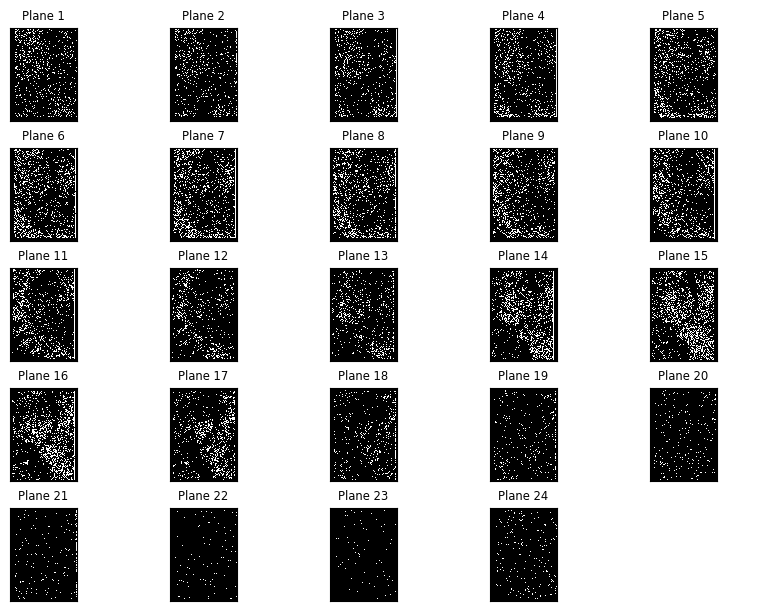

In [39]:
tfu.show_tif_all_planes(corr_map_thresh, vminmax=(0.002,0.0021))

In [40]:
%%time
# 30min14sec
tic = time.time()
job.params['peak_thresh'] = 0.02

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.03
job.params['activity_thresh'] = 5.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['segmentation_timebin'] = 1
job.params['patch_size_xy'] = (150, 150)
# 4min46 for 5bin and 4 patches
# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=corr_map_thresh,)
toc = time.time()

      Found dir /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/segmentation and /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 54
      Found dir /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/segmentation/patch-0000
         Loading 8.23 GB movie to memory, shape: (8184, 24, 150, 150) 
         Loaded
         Loading movie patch 

In [ ]:
job.compute_npil_masks(stats_dir = job.dirs['rois'])



traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'])

job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')

   Updated main params file
   Movie shape: (24, 49106, 1037, 746)
44183
   Extracting 44183 valid cells, and saving cell flags to /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 99 batches of 500
   Saving intermediate results to /mnt/md0/runs/s3d-SS004_2024-08-13_1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20/rois
